In [1]:
import random
from transformers import pipeline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
import numpy as np
from huggingface_hub import notebook_login
import wandb
import os
import time
import json
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, get_linear_schedule_with_warmup

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina' # 主题

In [3]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
plt.rcParams['figure.figsize'] = 12, 8

In [4]:
# print(torch.__version__)
# print(torch.backends.cudnn.version())
# print(torchvision.__version__)
# print(torchtext.__version__)

In [5]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark     = False  # 启用Cudnn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [6]:
# 模型相关参数

base_model_name = 'roberta-llama3.1405B-twitter-sentiment'
TEST_DATASET_SIZE = 0.4
NUM_LABELS = 3
# BASE_MODEL_PATH = f'./citation_finetuned_models/{base_model_name}'
BASE_MODEL_PATH = f'../pretrain_models/{base_model_name}'

# 训练相关参数
BATCH_SIZE = 32
loss_type='focal_loss' # 自定义参数 focal_loss dsc_loss ce_loss asymmetric_loss
weight_decay = 0.05  # 0.01
lr = 2.0e-5  # 2e-5学习率，bs设置较大 5e-6
num_epochs = 1
warmup_ratio = 0.1
warmup_steps = 100
label_smoothing_factor = 0.1

# notebook_login()
os.environ["WANDB_PROJECT"] = base_model_name
os.environ["WANDB_LOG_MODEL"] = 'true' # save your trained model checkpoint to wandb
os.environ["WANDB_WATCH"] = 'false' # turn off watch to log faster

## 使用Trainer类微调citation的情感分析

In [7]:
label2id = {"background": 0, "method": 1, "result": 2}
id2label = {v: k for k, v in label2id.items()}

# 加载基座模型和分词器
model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL_PATH, num_labels=NUM_LABELS, id2label=id2label, label2id=label2id).to(device)
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_PATH)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ../pretrain_models/roberta-llama3.1405B-twitter-sentiment and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
import datasets

class MyDataset(torch.utils.data.Dataset):
    """
    重构数据集类，使其能够返回字典格式的数据，有标签
    """
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


def load_intent_datasets():

    def read_jsonl(file_path):
        citations = []
        intents = []
        with open(file_path, 'r', encoding='utf-8') as f:
            for line in f:
                entry = json.loads(line.strip())
                citation = entry.get('citation')
                citation_intent = entry.get('citation_intent')
                if citation and citation_intent:
                    citation_intent_id = label2id.get(citation_intent, -1)  # Use -1 for unknown labels
                    citations.append(citation)
                    intents.append(citation_intent_id)
        return citations, intents

    train_citations, train_intents = read_jsonl('../data/controllable-citation-generation/train.jsonl')
    test_citations, test_intents = read_jsonl('../data/controllable-citation-generation/test.jsonl')
    val_citations, val_intents = read_jsonl('../data/controllable-citation-generation/val.jsonl')
    return train_citations, train_intents, test_citations, test_intents, val_citations, val_intents

train_texts, train_labels, test_texts, test_labels, val_texts, val_labels = load_intent_datasets()

train_dataset = MyDataset(tokenizer(train_texts, truncation=True, padding=True, return_tensors='pt', max_length=512), train_labels)
test_dataset = MyDataset(tokenizer(test_texts, truncation=True, padding=True, return_tensors='pt', max_length=512), test_labels)
val_dataset = MyDataset(tokenizer(val_texts, truncation=True, padding=True, return_tensors='pt', max_length=512), val_labels)

# # 将数据转换为 HuggingFace 的 Dataset 格式
# train_data = datasets.Dataset.from_dict({'text': train_texts, 'label': train_labels})
# val_data = datasets.Dataset.from_dict({'text': val_texts, 'label': val_labels})
# test_data = datasets.Dataset.from_dict({'text': test_texts, 'label': test_labels})
# emotion_data = datasets.DatasetDict({'train': train_data, 'validation': val_data, 'test': test_data})
# tokenized_data = emotion_data.map(lambda f: tokenizer(f['text'], padding=True, truncation=True, return_tensors='pt', max_length=512), batch_size=16, batched=True)  # WordPiece分词器
# tokenized_data = tokenized_data.remove_columns(['text'])
# train_dataset = tokenized_data['train']
# val_dataset = tokenized_data['validation']
# test_dataset = tokenized_data['test']

print(f"Train Dataset Size: {len(train_dataset)}")
print(f"Test Dataset Size: {len(test_dataset)}")
print(f"Val Dataset Size: {len(val_dataset)}")

Train Dataset Size: 233616
Test Dataset Size: 1080
Val Dataset Size: 1299


In [9]:
# 使用Focal loss作为损失函数解决样本不均衡问题
class MultiFocalLoss(torch.nn.Module):
    """
    Focal_Loss= -1*alpha*((1-pt)**gamma)*log(pt)
    Args:
        num_class: number of classes
        alpha: class balance factor shape=[num_class, ]
        gamma: hyperparameter
        reduction: reduction type
    """

    def __init__(self, num_class, alpha=None, gamma=2.0, reduction='mean'):
        super(MultiFocalLoss, self).__init__()
        self.num_class = num_class
        self.gamma = gamma
        self.reduction = reduction
        self.smooth = 1e-4
        self.alpha = alpha
        
        if alpha is None:
            self.alpha = torch.ones(num_class, ) - 0.5
        elif isinstance(alpha, (int, float)):
            self.alpha = torch.as_tensor([alpha] * num_class)
        elif isinstance(alpha, (list, np.ndarray)):
            self.alpha = torch.as_tensor(alpha)
        if self.alpha.shape[0] != num_class:
            raise RuntimeError('the length not equal to number of class')

    def forward(self, logit, target):
        # assert isinstance(self.alpha,torch.Tensor)\
        alpha = self.alpha.to(logit.device)
        prob = F.softmax(logit, dim=1)

        if prob.dim() > 2:
            # used for 3d-conv:  N,C,d1,d2 -> N,C,m (m=d1*d2*...)
            N, C = logit.shape[:2]
            prob = prob.view(N, C, -1)
            prob = prob.transpose(1, 2).contiguous()  # [N,C,d1*d2..] -> [N,d1*d2..,C]
            prob = prob.view(-1, prob.size(-1))  # [N,d1*d2..,C]-> [N*d1*d2..,C]

        ori_shp = target.shape
        target = target.view(-1, 1)

        prob = prob.gather(1, target).view(-1) + self.smooth  # avoid nan
        logpt = torch.log(prob)
        # alpha_class = alpha.gather(0, target.squeeze(-1))
        alpha_weight = alpha[target.squeeze().long()]
        loss = -alpha_weight * torch.pow(torch.sub(1.0, prob), self.gamma) * logpt

        if self.reduction == 'mean':
            loss = loss.mean()
        elif self.reduction == 'none':
            loss = loss.view(ori_shp)

        return loss

# DSELoss
class MultiDSCLoss(torch.nn.Module):
    r"""
    Creates a criterion that optimizes a multi-class Self-adjusting Dice Loss
    ("Dice Loss for Data-imbalanced NLP Tasks" paper)

    Args:
        alpha (float): a factor to push down the weight of easy examples
        gamma (float): a factor added to both the nominator and the denominator for smoothing purposes
        reduction (string): Specifies the reduction to apply to the output:
            ``'none'`` | ``'mean'`` | ``'sum'``. ``'none'``: no reduction will be applied,
            ``'mean'``: the sum of the output will be divided by the number of
            elements in the output, ``'sum'``: the output will be summed.

    Shape:
        - logits: `(N, C)` where `N` is the batch size and `C` is the number of classes.
        - targets: `(N)` where each value is in [0, C - 1]
    """

    def __init__(self, alpha=1.0, smooth=1.0, reduction="mean"):
        super(MultiDSCLoss, self).__init__()
        self.alpha = alpha
        self.smooth = smooth
        self.reduction = reduction

    def forward(self, logits, targets):
        probs = torch.softmax(logits, dim=1)
        probs = torch.gather(probs, dim=1, index=targets.unsqueeze(1))

        probs_with_factor = ((1 - probs) ** self.alpha) * probs
        loss = 1 - (2 * probs_with_factor + self.smooth) / (probs_with_factor + 1 + self.smooth)

        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        elif self.reduction == "none" or self.reduction is None:
            return loss
        else:
            raise NotImplementedError(f"Reduction `{self.reduction}` is not supported.")

# Asymmetric Loss
class AsymmetricLoss(torch.nn.Module):
    """ 
    Notice - optimized version, minimizes memory allocation and gpu uploading,
    favors inplace operations
    """
    def __init__(self, gamma_neg=4, gamma_pos=1, clip=0.05, eps=1e-8, disable_torch_grad_focal_loss=False):
        super(AsymmetricLoss, self).__init__()

        self.gamma_neg = gamma_neg
        self.gamma_pos = gamma_pos
        self.clip = clip
        self.disable_torch_grad_focal_loss = disable_torch_grad_focal_loss
        self.eps = eps

        # prevent memory allocation and gpu uploading every iteration, and encourages inplace operations
        self.targets = self.anti_targets = self.xs_pos = self.xs_neg = self.asymmetric_w = self.loss = None

    def forward(self, x, y):
        """"
        Parameters
        ----------
        x: input logits
        y: targets (multi-label binarized vector)
        """

        self.targets = y
        self.anti_targets = 1 - y

        # Calculating Probabilities
        self.xs_pos = torch.sigmoid(x)
        self.xs_neg = 1.0 - self.xs_pos

        # Asymmetric Clipping
        if self.clip is not None and self.clip > 0:
            self.xs_neg.add_(self.clip).clamp_(max=1)

        # Basic CE calculation
        self.loss = self.targets * torch.log(self.xs_pos.clamp(min=self.eps))
        self.loss.add_(self.anti_targets * torch.log(self.xs_neg.clamp(min=self.eps)))

        # Asymmetric Focusing
        if self.gamma_neg > 0 or self.gamma_pos > 0:
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(False)
            self.xs_pos = self.xs_pos * self.targets
            self.xs_neg = self.xs_neg * self.anti_targets
            self.asymmetric_w = torch.pow(1 - self.xs_pos - self.xs_neg,
                                          self.gamma_pos * self.targets + self.gamma_neg * self.anti_targets)
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(True)
            self.loss *= self.asymmetric_w

        return -self.loss.sum()


class CustomTrainer(Trainer):
    def __init__(self, loss_type='focal_loss', *args, **kwargs):
        super(CustomTrainer, self).__init__(*args, **kwargs)
        self.loss_type = loss_type

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        if self.loss_type == 'focal_loss':
            loss_fct = MultiFocalLoss(num_class=3, alpha=0.8, gamma=2.0)
        elif self.loss_type == 'dsc_loss':
            loss_fct = MultiDSCLoss(alpha=1.0, smooth=1.0)
        elif self.loss_type == 'asymmetric_loss':
            loss_fct = AsymmetricLoss(gamma_pos=0.5, gamma_neg=3.0)
        elif self.loss_type == 'ce_loss':
            loss_fct = torch.nn.CrossEntropyLoss()
        else:
            loss_fct = torch.nn.CrossEntropyLoss()
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [10]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import TrainerCallback

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    class_weights = np.bincount(labels) / len(labels)
    sample_weights = class_weights[labels]
    weighted_accuracy = accuracy_score(labels, preds, sample_weight=sample_weights)

    return {
        'Accuracy': acc,
        'Weighted Accuracy': weighted_accuracy,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

class LossRecorderCallback(TrainerCallback):
    def __init__(self):
        self.train_losses = []
        self.eval_losses = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if 'loss' in logs:
            self.train_losses.append(logs['loss'])
        if 'eval_loss' in logs:
            self.eval_losses.append(logs['eval_loss'])

    def plot_losses(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.train_losses, label='Training Loss')
        plt.plot(self.eval_losses, label='Validation Loss')
        plt.xlabel('Steps')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Training and Validation Loss over Time')
        plt.show()

loss_recorder = LossRecorderCallback()

In [11]:
# 定义训练参数
training_args = TrainingArguments(
    output_dir=f'./results/{base_model_name}',          # 输出结果目录
    report_to='none',
    num_train_epochs=num_epochs,
    learning_rate=lr,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    weight_decay=weight_decay,
    warmup_ratio=warmup_ratio,
    # warmup_steps=warmup_steps,
    logging_strategy='steps',
    logging_dir=f'./logs/{base_model_name}',            # 日志目录
    logging_steps=50,
    eval_strategy="steps",
    eval_steps=50,
    disable_tqdm=False,
    save_strategy="steps",
    fp16= torch.cuda.is_available(), # faster and use less memory
    metric_for_best_model='F1',
    load_best_model_at_end=True,
    greater_is_better=True,
    # push_to_hub=True,
    # label_smoothing_factor=label_smoothing_factor
)

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    loss_type=loss_type,  # 自定义参数 focal_loss dsc_loss
    callbacks=[loss_recorder]
)

start = time.time()
trainer.train()
train_time = time.time() - start
print(f"Training took: {train_time:.2f} seconds")
eval_result = trainer.evaluate()

loss_recorder.plot_losses()

Step,Training Loss,Validation Loss,Accuracy,Weighted accuracy,F1,Precision,Recall
50,0.400700,0.367524,0.408006,0.403892,0.284102,0.537875,0.376561
100,0.278300,0.314604,0.611239,0.677101,0.450564,0.422157,0.506575
150,0.214800,0.224255,0.686682,0.764879,0.563697,0.775705,0.577877
200,0.157600,0.129185,0.819861,0.845731,0.804466,0.831817,0.787890
250,0.111300,0.101194,0.849885,0.866782,0.845893,0.867403,0.830760
300,0.103600,0.103974,0.845266,0.872228,0.838893,0.878736,0.818370
350,0.091000,0.096448,0.855273,0.867184,0.856553,0.886902,0.854787
400,0.079900,0.089939,0.863741,0.883823,0.861394,0.890468,0.844473
450,0.079900,0.065816,0.893764,0.889422,0.900117,0.899463,0.901120
500,0.075700,0.062399,0.892995,0.894075,0.895784,0.896331,0.898331


D:\User\anaconda3\envs\cu121torch230\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training took: 652.28 seconds


# k-fold cross validation

In [12]:
# from sklearn.model_selection import KFold
# 
# # k折交叉验证
# k = 10
# kf = KFold(n_splits=k, shuffle=True, random_state=seed)
# 
# train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.1, stratify=labels, random_state=seed)
# results = []
# fold_counter = 1
# for train_index, val_index in kf.split(train_texts):
#     print(f"Training fold {fold_counter}/{k}")
#     fold_train_texts = [train_texts[i] for i in train_index]
#     fold_val_texts = [train_texts[i] for i in val_index]
#     fold_train_labels = [train_labels[i] for i in train_index]
#     fold_val_labels = [train_labels[i] for i in val_index]
# 
#     train_dataset = MyDataset(tokenizer(fold_train_texts, truncation=True, padding=True, return_tensors='pt', max_length=512), fold_train_labels)
#     val_dataset = MyDataset(tokenizer(fold_val_texts, truncation=True, padding=True, return_tensors='pt', max_length=512), fold_val_labels)
# 
#     # 独立的k次训练
#     model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL_PATH, num_labels=NUM_LABELS, id2label=id2label, label2id=label2id).to(device)
# 
#     # 定义训练参数
#     training_args = TrainingArguments(
#         output_dir=f'./results/{base_model_name}',          # 输出结果目录
#         report_to='none',
#         num_train_epochs=num_epochs,
#         learning_rate=lr,
#         per_device_train_batch_size=BATCH_SIZE,
#         per_device_eval_batch_size=BATCH_SIZE,
#         weight_decay=weight_decay,
#         warmup_ratio=warmup_ratio,
#         # warmup_steps=warmup_steps,
#         logging_strategy='steps',
#         logging_dir=f'./logs/{base_model_name}',            # 日志目录
#         logging_steps=50,
#         eval_strategy="steps",
#         eval_steps=50,
#         disable_tqdm=False,
#         save_strategy="steps",
#         fp16= torch.cuda.is_available(), # faster and use less memory
#         metric_for_best_model='F1',
#         load_best_model_at_end=True,
#         greater_is_better=True,
#         # push_to_hub=True,
#         # label_smoothing_factor=label_smoothing_factor
#     )
# 
#     trainer = CustomTrainer(
#         model=model,
#         args=training_args,
#         train_dataset=train_dataset,
#         eval_dataset=val_dataset,
#         tokenizer=tokenizer,
#         compute_metrics=compute_metrics,
#         loss_type=loss_type,  # 自定义参数 focal_loss dsc_loss
#         callbacks=[loss_recorder]
#     )
# 
#     start = time.time()
#     trainer.train()
#     train_time = time.time() - start
#     print(f"Training took: {train_time:.2f} seconds")
#     eval_result = trainer.evaluate()
#     results.append(eval_result)
#     
#     # 对测试集进行评估
#     test_dataset = MyDataset(tokenizer(test_texts, truncation=True, padding=True, return_tensors='pt', max_length=512), test_labels)
#     test_results = trainer.evaluate(test_dataset)
#     print(f"Test results for fold {fold_counter}: {test_results}")
# 
#     loss_recorder.plot_losses()
#     fold_counter += 1
# 
# # 计算平均结果
# avg_results = {key: np.mean([result[key] for result in results]) for key in results[0]}
# print("Average results:", avg_results)

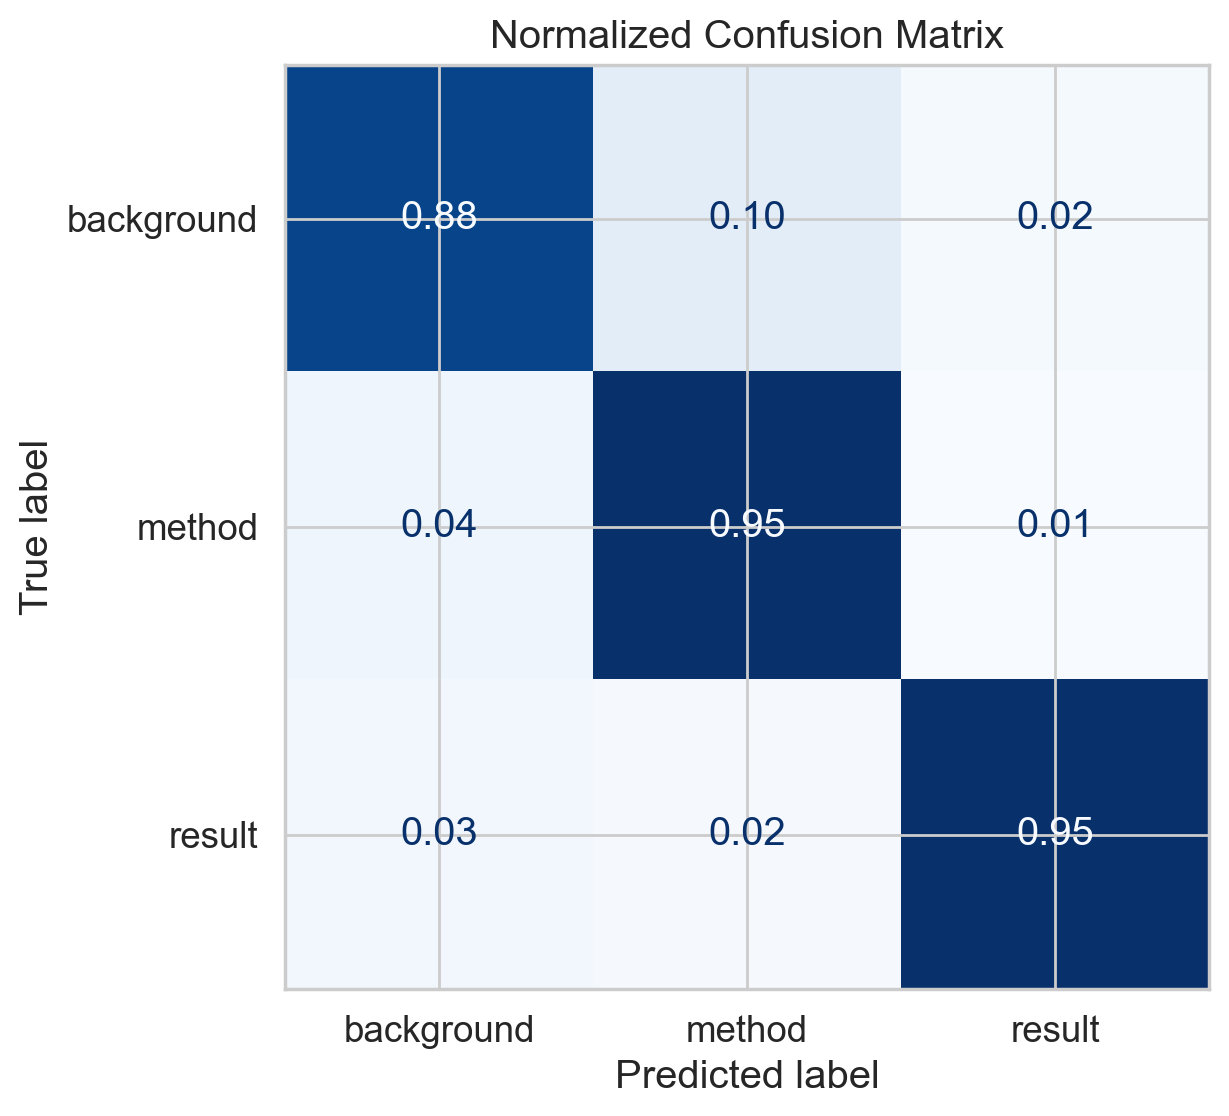

In [13]:
from plot_results import plot_confusion_matrix

test_result = trainer.predict(test_dataset)
test_preds = test_result.predictions.argmax(-1)
test_labels = test_dataset.labels

plot_confusion_matrix(test_labels, test_preds, list(label2id.keys()))

## intent微调后标注新数据集

In [15]:
from torch.utils.data import DataLoader

saved_model_dir = f'../citation_finetuned_models/{base_model_name}'
trainer.save_model(saved_model_dir)
saved_model = AutoModelForSequenceClassification.from_pretrained(saved_model_dir).to(device)

def load_sentiment_datasets(test_size=0.4, seed=42, filepath='../data/corpus.txt', is_split=True):
    sentences, labels = [], []
    if filepath == '../data/citation_sentiment_corpus.csv':
        df = pd.read_csv(filepath)
        label_map = {'o': 0, 'p': 1, 'n': 2}
        df['Sentiment'] = df['Sentiment'].map(label_map)
        sentences = df['Citation_Text'].tolist()
        labels = df['Sentiment'].tolist()
    elif filepath == '../data/citation_sentiment_corpus_balanced.csv':
        df = pd.read_csv(filepath)
        df = df[(df['Source'] == 'new') & (df['Sentiment'].isin([1, 2])) | (df['Source'] == 'original') & (
                    df['Sentiment'] == 0)] # 只选取新数据集中的正负样本和原始数据集中的中性样本
        sentences = df['Citation_Text'].tolist()
        labels = df['Sentiment'].tolist()
    elif filepath == '../data/corpus.txt':
        with open(filepath, "r", encoding="utf8") as f:
            file = f.read().split("\n")
            file = [i.split("\t") for i in file]
            for i in file:
                if len(i) == 2:
                    sentence = i[1]
                    label = int(i[0])
                    # Map labels: 2 -> Positive, 1 -> Neutral, 0 -> Negative
                    if label == 2:
                        label = 1
                    elif label == 1:
                        label = 0
                    elif label == 0:
                        label = 2
                    sentences.append(sentence)
                    labels.append(label)
    elif filepath == '../data/CSA_raw_dataset/augmented_context_full/combined.csv':
        df = pd.read_csv(filepath)
        labelmap = {'Neutral': 0, 'Positive': 1, 'Negative': 2}
        df['Sentiment'] = df['Sentiment'].map(labelmap)
        sentences = df['Text'].tolist()
        labels = df['Sentiment'].tolist()

    if is_split:
        train_texts, temp_texts, train_labels, temp_labels = train_test_split(sentences, labels, test_size=test_size,
                                                                              stratify=labels, random_state=seed)

        val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts, temp_labels, test_size=0.5,
                                                                          stratify=temp_labels, random_state=seed)
        return train_texts, train_labels, val_texts, val_labels, test_texts, test_labels
    else:
        return sentences, labels

texts, labels = load_sentiment_datasets(seed=seed, filepath='../data/citation_sentiment_corpus.csv', is_split=False)

def predict_intents(model, tokenizer, texts, device, batch_size=32):
    model.to(device)
    model.eval()

    # Create DataLoader
    dataset = MyDataset(tokenizer(texts, truncation=True, padding=True, return_tensors='pt', max_length=512), [0]*len(texts))
    dataloader = DataLoader(dataset, batch_size=batch_size)
    
    all_predictions = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader):
            inputs = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
            outputs = model(**inputs)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1).cpu().numpy()
            all_predictions.extend(predictions)
    
    return all_predictions

predictions = predict_intents(saved_model, tokenizer, texts, device, batch_size=BATCH_SIZE)

df = pd.DataFrame({'text': texts, 'sentiment': labels, 'intent': predictions})
df.to_csv("../output/corpus_with_intent_bert.csv", index=False)

100%|██████████| 273/273 [00:39<00:00,  6.86it/s]
